In [1]:
import os
import numpy as np
import pandas as pd
import random
import seaborn as sns

import datetime as datetime
import matplotlib.dates as dates
import matplotlib.pyplot as plt

from contextlib import contextmanager
from time import time
from tqdm import tqdm


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline

import datetime
from datetime import date

In [2]:
df = pd.read_csv('covid_19_indonesia_time_series_all.csv')
df.head(5)

,Date,Location ISO Code,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,...,Latitude,New Cases per Million,Total Cases per Million,New Deaths per Million,Total Deaths per Million,Total Deaths per 100rb,Case Fatality Rate,Case Recovered Rate,Growth Factor of New Cases,Growth Factor of New Deaths
0,3/1/2020,ID-JK,DKI Jakarta,2,0,0,2,39,20,41,...,-6.204699,0.18,3.60,0.0,1.84,0.18,51.28%,105.13%,NaN,NaN
1,3/2/2020,ID-JK,DKI Jakarta,2,0,0,2,41,20,41,...,-6.204699,0.18,3.78,0.0,1.84,0.18,48.78%,100.00%,1.0,1.0
2,3/2/2020,IDN,Indonesia,2,0,0,2,2,0,0,...,-0.789275,0.01,0.01,0.0,0.00,0.00,0.00%,0.00%,NaN,NaN
3,3/2/2020,ID-RI,Riau,1,0,0,1,2,0,3,...,0.511648,0.16,0.33,0.0,0.00,0.00,0.00%,150.00%,NaN,NaN
4,3/3/2020,ID-JK,DKI Jakarta,2,0,0,2,43,20,41,...,-6.204699,0.18,3.96,0.0,1.84,0.18,46.51%,95.35%,1.0,1.0


In [3]:
date2=[]
for item in df['Date']:
    item2=item.split('/')
    month=int(item2[0])
    day=int(item2[1])
    year=int(item2[2])
    date2+=[datetime.date(year,month,day)]
df['Date']=date2
df['Date'] = pd.to_datetime(df['Date'])

In [4]:
data = df.drop(['City or Regency','Location ISO Code',
                'Province','Country','Continent','Island','Time Zone','Special Status',
                'Total Regencies','Total Cities','Total Districts','Total Urban Villages',
                'Total Rural Villages','New Cases per Million','Total Cases per Million',
                'New Deaths per Million','Total Deaths per Million','Case Fatality Rate',
                'Case Recovered Rate','Growth Factor of New Cases','Growth Factor of New Deaths'],axis = 1)
data = data.fillna(0)
data.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude,Total Deaths per 100rb
0,2020-03-01,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
1,2020-03-02,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
2,2020-03-02,Indonesia,2,0,0,2,2,0,0,2,Country,1916907,265185520,138.34,113.921327,-0.789275,0.00
3,2020-03-02,Riau,1,0,0,1,2,0,3,-1,Province,87024,6074100,69.80,101.805109,0.511648,0.00
4,2020-03-03,DKI Jakarta,2,0,0,2,43,20,41,-18,Province,664,10846145,16334.31,106.836118,-6.204699,0.18


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21759 entries, 0 to 21758
Data columns (total 17 columns):
Date                      21759 non-null datetime64[ns]
Location                  21759 non-null object
New Cases                 21759 non-null int64
New Deaths                21759 non-null int64
New Recovered             21759 non-null int64
New Active Cases          21759 non-null int64
Total Cases               21759 non-null int64
Total Deaths              21759 non-null int64
Total Recovered           21759 non-null int64
Total Active Cases        21759 non-null int64
Location Level            21759 non-null object
Area (km2)                21759 non-null int64
Population                21759 non-null int64
Population Density        21759 non-null float64
Longitude                 21759 non-null float64
Latitude                  21759 non-null float64
Total Deaths per 100rb    21759 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(10), object(2)
memory usage:

In [6]:
data1 = data[data['Location Level'] != 'Country']
data1.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude,Total Deaths per 100rb
0,2020-03-01,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
1,2020-03-02,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
3,2020-03-02,Riau,1,0,0,1,2,0,3,-1,Province,87024,6074100,69.80,101.805109,0.511648,0.00
4,2020-03-03,DKI Jakarta,2,0,0,2,43,20,41,-18,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
6,2020-03-03,Jawa Barat,1,1,0,0,1,1,8,-8,Province,35378,45161325,1276.55,107.603708,-6.920432,0.00


In [7]:
newest = data1.drop_duplicates(subset='Location', keep="last")
newest.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude,Total Deaths per 100rb
21364,2021-11-21,Gorontalo,1,0,0,1,11834,460,11374,0,Province,11257,1180651,104.88,122.376058,0.687003,38.96
21617,2021-11-28,Maluku Utara,2,0,3,-1,12101,303,11757,41,Province,31983,1307803,40.89,127.539107,0.212037,23.17
21700,2021-12-01,Bengkulu,1,0,0,1,23104,473,22612,19,Province,19919,1999539,100.38,102.338421,-3.533584,23.66
21712,2021-12-01,Kalimantan Utara,1,0,0,1,35885,811,35039,35,Province,75468,648407,8.59,116.218879,2.891013,125.08
21714,2021-12-01,Kepulauan Riau,2,0,0,2,53884,1748,52120,16,Province,8202,1929400,235.24,108.261746,3.916346,90.60


In [8]:
# Memanggil Data COVID 19 as per updated 2 Desember 2021
newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude,Total Deaths per 100rb
21733,2021-12-02,DKI Jakarta,28,0,0,28,864045,13596,849875,574,Province,664,10846145,16334.31,106.836118,-6.204699,125.35
21737,2021-12-02,Jawa Barat,83,0,6,77,707934,14737,692101,1096,Province,35378,45161325,1276.55,107.603708,-6.920432,32.63
21738,2021-12-02,Jawa Tengah,30,1,6,23,486435,30225,454837,1373,Province,32801,36364072,1108.64,110.201115,-7.259097,83.12
21739,2021-12-02,Jawa Timur,35,0,11,24,399478,29697,369537,244,Province,47803,40479023,846.78,112.732941,-7.723346,73.36
21743,2021-12-02,Kalimantan Timur,7,0,2,5,158245,5449,152714,82,Province,129067,3552191,27.52,116.468440,0.453858,153.40
21734,2021-12-02,Daerah Istimewa Yogyakarta,7,0,0,7,156769,5263,150965,541,Province,3133,3631015,1158.90,110.444878,-7.894502,144.95
21732,2021-12-02,Banten,16,0,1,15,132693,2688,129872,133,Province,9663,10722374,1109.64,106.109004,-6.456736,25.07
21750,2021-12-02,Riau,4,0,0,4,128825,4109,124123,593,Province,87024,6074100,69.80,101.805109,0.511648,67.65
21731,2021-12-02,Bali,15,1,1,13,114233,4046,110003,184,Province,5780,4216171,729.43,115.131714,-8.369472,95.96
21751,2021-12-02,Sulawesi Selatan,1,1,1,-1,109919,2238,107630,51,Province,46717,9426885,201.78,120.162056,-3.731081,23.74


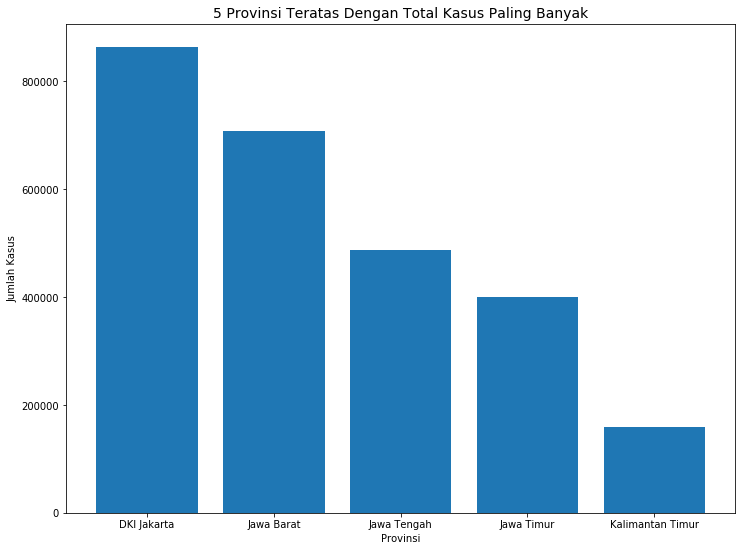

In [9]:
# Provinsi dengan Total Kasus Terbanyak
plt.figure(figsize=(12,9))
plt.bar(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Location'].values[:5], newest[newest.Location != 'Indonesia'].sort_values(by=['Total Cases'], ascending=False)['Total Cases'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kasus Paling Banyak', fontsize=14)
plt.xlabel('Provinsi')
plt.ylabel('Jumlah Kasus')
plt.show()

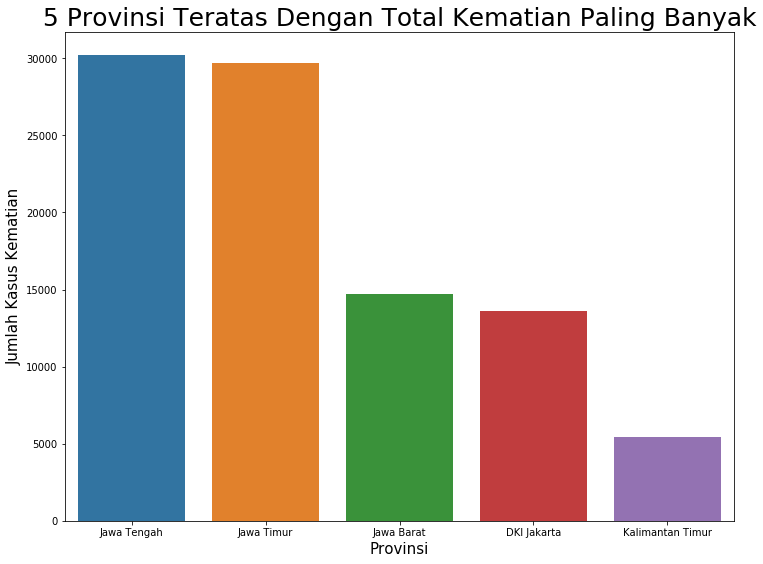

In [10]:
# Provinsi dengan Angka Kematian Terbanyak
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], ascending=False)['Location'].values[:5],  newest[newest.Location != 'Indonesia'].sort_values(by=['Total Deaths'], ascending=False)['Total Deaths'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kematian Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Jumlah Kasus Kematian', fontsize=15)
plt.show()

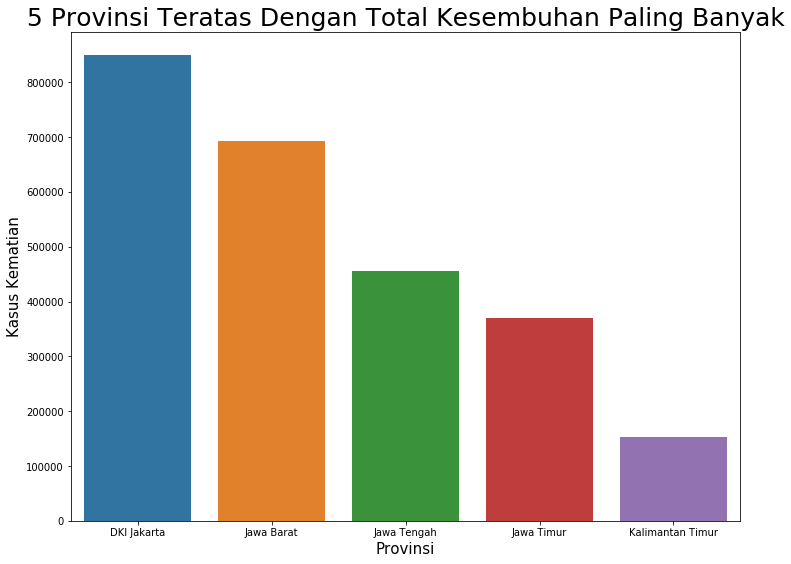

In [11]:
# Provinsi dengan Angka Kesembuhan Terbanyak
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Recovered'], ascending=False)['Location'].values[:5],  newest[newest.Location != 'Indonesia'].sort_values(by=['Total Recovered'], ascending=False)['Total Recovered'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kesembuhan Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Kasus Kematian', fontsize=15)
plt.show()

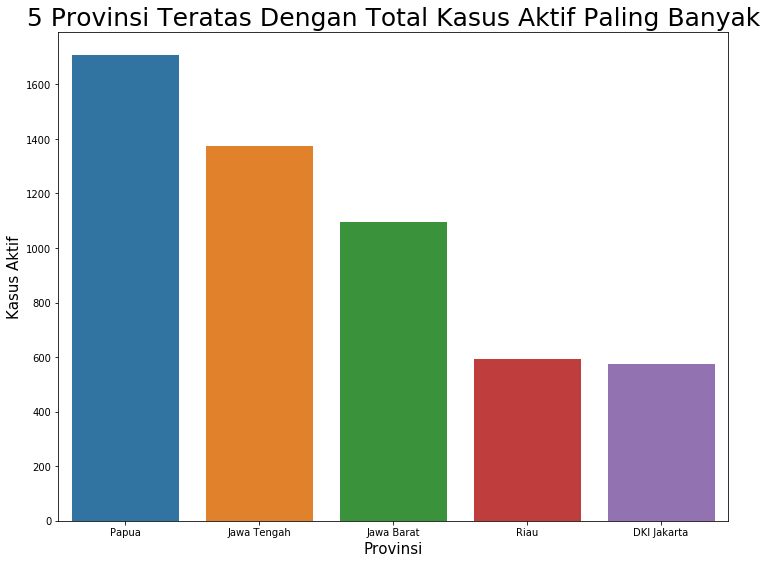

In [12]:
# Provinsi dengan Angka Kasus Aktif Terbanyak
plt.figure(figsize=(12,9))
sns.barplot(newest[newest.Location != 'Indonesia'].sort_values(by=['Total Active Cases'], ascending=False)['Location'].values[:5],  newest[newest.Location != 'Indonesia'].sort_values(by=['Total Active Cases'], ascending=False)['Total Active Cases'].values[:5])
plt.title('5 Provinsi Teratas Dengan Total Kasus Aktif Paling Banyak', fontsize=25)
plt.xlabel('Provinsi', fontsize=15)
plt.ylabel('Kasus Aktif', fontsize=15)
plt.show()

In [13]:
data1.head()

,Date,Location,New Cases,New Deaths,New Recovered,New Active Cases,Total Cases,Total Deaths,Total Recovered,Total Active Cases,Location Level,Area (km2),Population,Population Density,Longitude,Latitude,Total Deaths per 100rb
0,2020-03-01,DKI Jakarta,2,0,0,2,39,20,41,-22,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
1,2020-03-02,DKI Jakarta,2,0,0,2,41,20,41,-20,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
3,2020-03-02,Riau,1,0,0,1,2,0,3,-1,Province,87024,6074100,69.80,101.805109,0.511648,0.00
4,2020-03-03,DKI Jakarta,2,0,0,2,43,20,41,-18,Province,664,10846145,16334.31,106.836118,-6.204699,0.18
6,2020-03-03,Jawa Barat,1,1,0,0,1,1,8,-8,Province,35378,45161325,1276.55,107.603708,-6.920432,0.00


In [14]:
#Memfokuskan pada beberapa variable saja yang terkait dengan kasus Covid 19
data2 = data1[['New Deaths', 'New Cases','Total Cases', 'New Recovered', 'Total Recovered', 'Total Deaths','Population', 'Population Density']]
data2.head()

,New Deaths,New Cases,Total Cases,New Recovered,Total Recovered,Total Deaths,Population,Population Density
0,0,2,39,0,41,20,10846145,16334.31
1,0,2,41,0,41,20,10846145,16334.31
3,0,1,2,0,3,0,6074100,69.80
4,0,2,43,0,41,20,10846145,16334.31
6,1,1,1,0,8,1,45161325,1276.55


In [15]:
data3 = data1[['New Deaths', 'Total Deaths']]
data3.head()

,New Deaths,Total Deaths
0,0,20
1,0,20
3,0,0
4,0,20
6,1,1


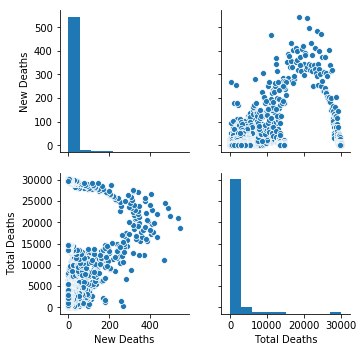

In [16]:
#Melihat korelasi antar variabel dari sebaran data pada scatter plot 
sns.pairplot(data3)
plt.show()

### Persiapan untuk permodelan data dan evaluasi performa model

#### Skala lokasi: Provinsi di Indonesia

In [17]:
# SPLIT DATA
X = data2.drop('New Deaths', axis = 1)
y = data2['New Deaths']

In [18]:
#Train_test_split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(15837, 7)
(5280, 7)
(15837,)
(5280,)


In [26]:
y_train.head(30)

18852     0
14601     8
12381     0
14689     0
17135    15
5586      2
13894     4
13681     5
8417     21
410       0
6221      0
9797      0
15681     1
17828    30
21030     0
14110     4
11301     1
155       0
7909      2
13893     0
18713    14
19497     1
13901     3
8792      0
17086    12
4904      3
13363     0
19757     4
7299     20
13658     1
Name: New Deaths, dtype: int64

In [68]:
#Scalling the Data, supaya nominal angka data bisa seragam (tidak terlalu besar Range-nya)
pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

In [69]:
def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')

MAE: 3.139747682170523
MSE: 110.45598926622324
RMSE: 10.509804435203504
R2 Square 0.8266904957899357
__________________________________


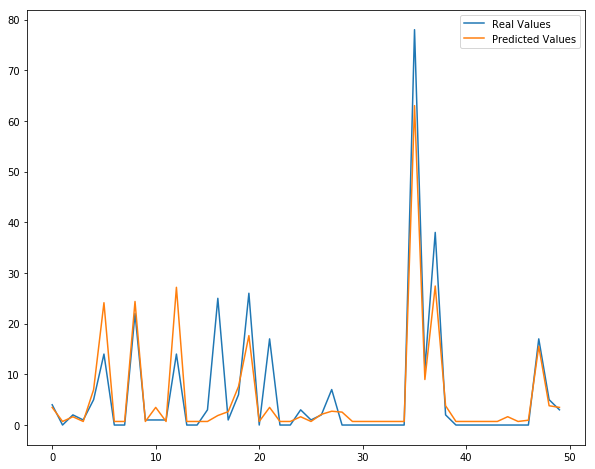

In [86]:
dct = RandomForestRegressor(n_estimators=10,max_depth=50, max_leaf_nodes=50)
dct.fit(X_train, y_train)

pred_dct = dct.predict(X_test)
print_evaluate(y_test, pred_dct)

df_dct = pd.DataFrame({'Real Values':y_test, 'Predicted Values':pred_dct})
df_dct.head()

plt.figure(figsize=(10,8))
plt.plot(df_dct['Real Values'].values[:50], label = 'Real Values')
plt.plot(df_dct['Predicted Values'].values[:50], label = 'Predicted Values')
plt.legend()
plt.show()

In [87]:
df_dct.head(10)

,Real Values,Predicted Values
7430,4,3.478288
688,0,0.704679
2713,2,1.632814
15607,1,0.704679
17889,5,6.971979
15802,14,24.131125
3899,0,0.704679
10351,0,0.704679
6494,22,24.376231
54,1,0.704679


In [88]:
dct.estimators_

[DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                       max_features='auto', max_leaf_nodes=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1765965412, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                       max_features='auto', max_leaf_nodes=50,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=105332827, splitter='best'),
 DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=50,
                       max_features='auto', max_leaf_nodes=50,
                       min_impurity_decrease=

[Text(396.3841463414634, 516.4200000000001, 'X[2] <= 3.326\nmse = 620.132\nsamples = 10004\nvalue = 6.361'),
 Text(144.60365853658536, 462.06000000000006, 'X[2] <= 0.285\nmse = 177.617\nsamples = 9898\nvalue = 4.757'),
 Text(54.4390243902439, 407.70000000000005, 'X[0] <= -0.04\nmse = 25.833\nsamples = 8987\nvalue = 2.347'),
 Text(27.21951219512195, 353.34000000000003, 'X[2] <= -0.171\nmse = 6.26\nsamples = 7880\nvalue = 1.304'),
 Text(13.609756097560975, 298.98, 'mse = 2.218\nsamples = 6351\nvalue = 0.734'),
 Text(40.829268292682926, 298.98, 'mse = 16.061\nsamples = 1529\nvalue = 3.657'),
 Text(81.65853658536585, 353.34000000000003, 'X[4] <= 0.165\nmse = 102.733\nsamples = 1107\nvalue = 9.9'),
 Text(68.04878048780488, 298.98, 'mse = 46.56\nsamples = 916\nvalue = 7.536'),
 Text(95.26829268292683, 298.98, 'mse = 214.863\nsamples = 191\nvalue = 22.111'),
 Text(234.7682926829268, 407.70000000000005, 'X[0] <= 1.758\nmse = 1050.537\nsamples = 911\nvalue = 28.42'),
 Text(136.09756097560975, 3

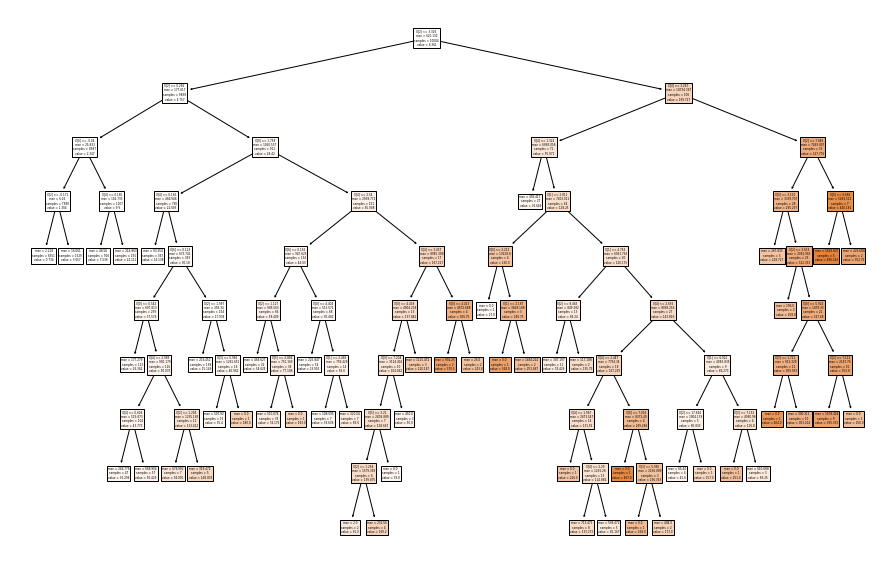

In [89]:
from sklearn import tree

plt.figure(figsize=(15,10))
tree.plot_tree(dct.estimators_[2],filled=True)

In [ ]:
plt.figure(figsize=(15,10))
for i in range(len(dct.estimators_)):
    tree.plot_tree(dct.estimators_[i],filled=True)